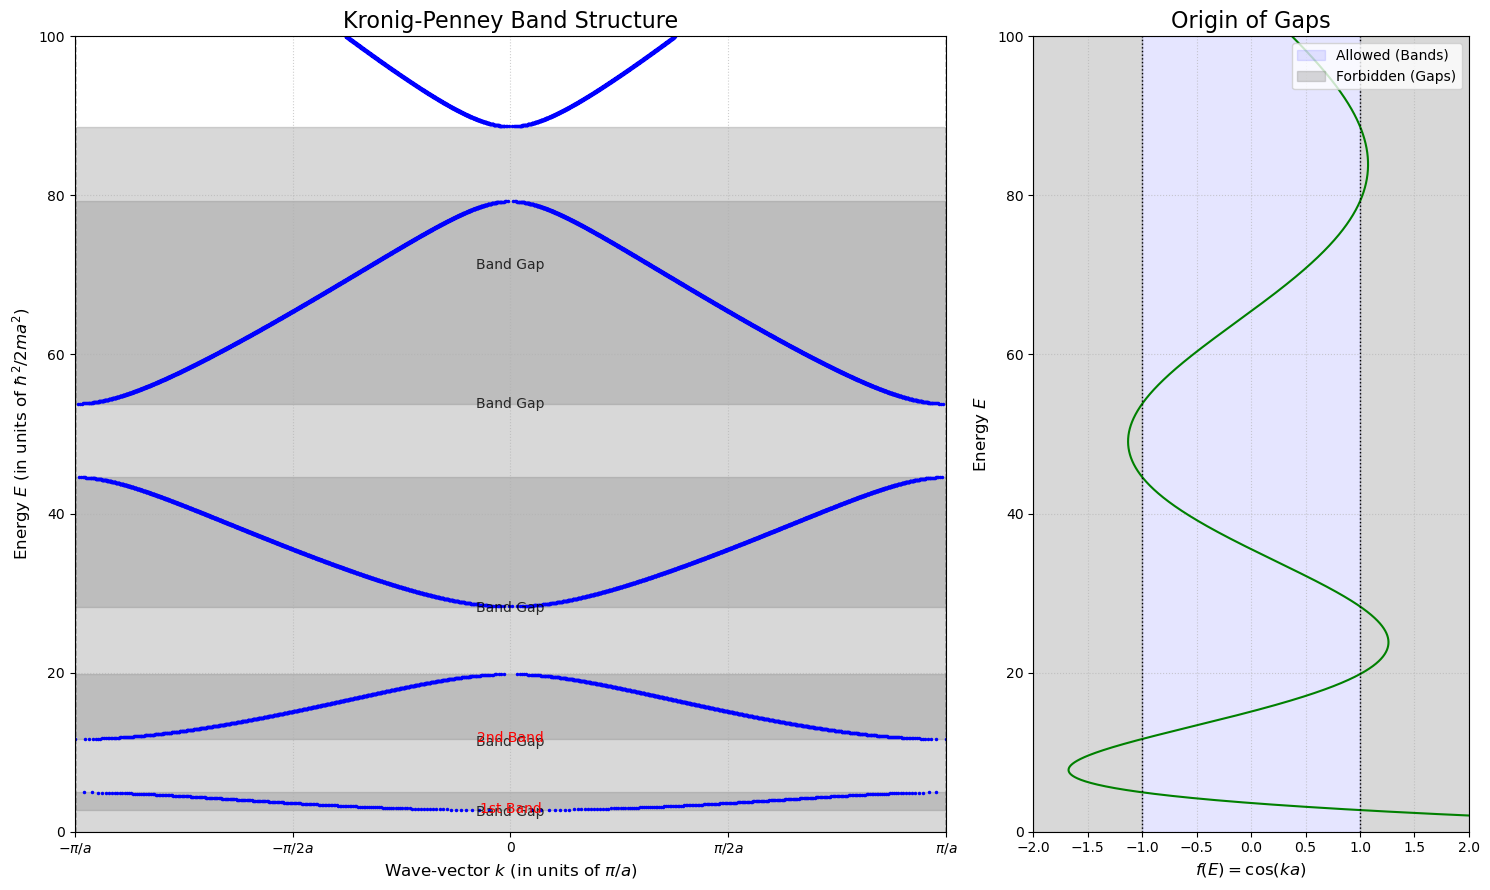

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define Constants & Parameters ---
# We use 'natural' units where hbar^2 / 2m = 1
HBAR2_over_2M = 0.5

a = 1.0       # Period of the lattice
b = 0.05       # Width of the barrier
U = 100.0     # Height of the barrier
V0 = U * b    # Barrier strength (for Dirac comb limit, not used here)

N_E = 10000    # Number of energy points to scan
E_max = 100.0003 # Maximum energy to scan

# --- 2. Define the RHS of the Kronig-Penney Relation ---
def kronig_penney_rhs(E, U, a, b):
    """Calculates the RHS of the Kronig-Penney dispersion relation."""
    c = a - b # Width of the well
    
    # Handle the three energy regimes
    if E == U:
        q = np.sqrt(E / HBAR2_over_2M)
        # Special case E=U, beta=0. Use limit of sinh(x)/x -> 1
        return np.cos(q*c) - (q*b/2.0) * np.sin(q*c)
    
    elif E > U:
        # E > U (scattering states, beta is imaginary)
        q = np.sqrt(E / HBAR2_over_2M)
        beta_prime = np.sqrt((E - U) / HBAR2_over_2M)
        
        return (np.cos(q*c) * np.cos(beta_prime*b) -
                0.5 * (q/beta_prime + beta_prime/q) * np.sin(q*c) * np.sin(beta_prime*b))
    
    else: # E < U (bound states, beta is real)
        q = np.sqrt(E / HBAR2_over_2M)
        beta = np.sqrt((U - E) / HBAR2_over_2M)
        
        return (np.cos(q*c) * np.cosh(beta*b) +
                0.5 * (beta/q - q/beta) * np.sin(q*c) * np.sinh(beta*b))

# --- 3. Scan Energies and Find Allowed Bands ---
energies = np.linspace(0.01, E_max, N_E) # Start just above 0
rhs_values = np.array([kronig_penney_rhs(E, U, a, b) for E in energies])

# Filter for allowed bands (where -1 <= RHS <= 1)
allowed_mask = np.abs(rhs_values) <= 1.0
E_allowed = energies[allowed_mask]
rhs_allowed = rhs_values[allowed_mask]

# Calculate k for the allowed bands
# k = (1/a) * arccos(RHS)
k_values = np.arccos(rhs_allowed) / a

# --- 4. Plot the Results ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9),
                               gridspec_kw={'width_ratios': [2, 1]})

# --- Plot 1: E(k) Band Diagram ---
# Plot k and -k to fill the Brillouin Zone
ax1.plot(k_values, E_allowed, '.', markersize=3, color='blue')
ax1.plot(-k_values, E_allowed, '.', markersize=3, color='blue')

# Formatting for Band Diagram
ax1.set_title('Kronig-Penney Band Structure', fontsize=16)
# --- FIX: Added 'r' for raw strings ---
ax1.set_xlabel(r'Wave-vector $k$ (in units of $\pi/a$)', fontsize=12)
ax1.set_ylabel(r'Energy $E$ (in units of $\hbar^2/2ma^2$)', fontsize=12)
ax1.set_xlim(-np.pi/a, np.pi/a)
ax1.set_ylim(0, E_max)

# Set x-ticks to be in terms of pi/a
ax1.set_xticks([-np.pi/a, -np.pi/(2*a), 0, np.pi/(2*a), np.pi/a])
# --- FIX: Added 'r' for raw strings ---
ax1.set_xticklabels([r'$-\pi/a$', r'$-\pi/2a$', '0', r'$\pi/2a$', r'$\pi/a$'])

# Add zone boundary lines
ax1.axvline(x=-np.pi/a, color='k', linestyle='--', linewidth=1)
ax1.axvline(x=np.pi/a, color='k', linestyle='--', linewidth=1)
ax1.grid(True, linestyle=':', alpha=0.6)

# Annotate bands and gaps
E_gaps = energies[~allowed_mask]
if len(E_gaps) > 0:
    gap_starts = E_gaps[np.where(np.diff(E_gaps) > 1.5*(E_max/N_E))[0]]
    gap_ends = E_gaps[np.where(np.diff(E_gaps) > 1.5*(E_max/N_E))[0] + 1]
    
    if E_gaps[0] < gap_starts[0]: gap_starts = np.insert(gap_starts, 0, E_gaps[0])
    if E_gaps[-1] > gap_ends[-1]: gap_ends = np.append(gap_ends, E_gaps[-1])

    for i in range(len(gap_ends)):
        ax1.axhspan(gap_starts[i], gap_ends[i], color='grey', alpha=0.3)
        ax1.text(0, (gap_starts[i] + gap_ends[i])/2, 'Band Gap', 
                 ha='center', va='center', color='black', alpha=0.8)

ax1.text(0, E_allowed[10], '1st Band', ha='center', va='center', color='red')
ax1.text(0, E_allowed[E_allowed > gap_ends[0]][10], '2nd Band', ha='center', va='center', color='red')

# --- Plot 2: RHS(E) to show gaps ---
ax2.plot(rhs_values, energies, color='green')
ax2.set_title('Origin of Gaps', fontsize=16)
# --- FIX: Added 'r' for raw string ---
ax2.set_xlabel(r'$f(E) = \cos(ka)$', fontsize=12)
ax2.set_ylabel('Energy $E$', fontsize=12)
ax2.set_ylim(0, E_max)
ax2.set_xlim(-2, 2)

# Highlight allowed/forbidden regions
ax2.axvspan(-1, 1, color='blue', alpha=0.1, label='Allowed (Bands)')
ax2.axvspan(-2, -1, color='grey', alpha=0.3, label='Forbidden (Gaps)')
ax2.axvspan(1, 2, color='grey', alpha=0.3)
ax2.axvline(x=-1, color='k', linestyle=':', linewidth=1)
ax2.axvline(x=1, color='k', linestyle=':', linewidth=1)
ax2.legend(loc='upper right')
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.savefig('1b.png',dpi='figure')
plt.show()